In [1]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelWithLMHead  # T5Base 50k

model_family = 'transformer'


c:\Users\zanex\Desktop\LM Sentiment Model\LMSentiment\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import glob
import os
from scipy.signal import find_peaks

### Data loading

In [ ]:

csv_folder = "reviews_and_scripts"
csv_pattern = os.path.join(csv_folder, "*_subtitle.csv")

In [ ]:

all_csv_files = glob.glob(csv_pattern)
print(f"Found {len(all_csv_files)} subtitle CSV files to process.")

Found 300 subtitle CSV files to process.


# Transformer Models

### 1. Multimodel reference

In [5]:
model_names = [
    "siebert/sentiment-roberta-large-english",
    "distilbert-base-uncased-finetuned-sst-2-english",
    "textattack/bert-base-uncased-imdb",
    "textattack/roberta-base-imdb",
    "finiteautomata/bertweet-base-sentiment-analysis",
    "pysentimiento/robertuito-sentiment-analysis",
    'mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'
    
]


In [ ]:

sentiment_pipes = {}
for name in model_names:
    sentiment_pipes[name] = pipeline("sentiment-analysis", model=name, device=0)

Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Some weights of the model checkpoint at textattack/roberta-base-imdb were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


In [ ]:
#############################################################################
# 3) every CSV，do emotion analysis and visulization.
#############################################################################
for csv_file in all_csv_files:
    print(f"\nProcessing: {csv_file}")


    df = pd.read_csv(csv_file, encoding="utf-8")
    

    if "Index" not in df.columns:
        df = df.reset_index().rename(columns={"index": "Index"})


    if "Sentence" not in df.columns:
        print(f"Warning: no 'Sentence' column found in {csv_file}. Skipping.")
        continue

    for model_name, sa_pipeline in sentiment_pipes.items():
       
        try:
            results = sa_pipeline(
                df["Sentence"].tolist(),
                batch_size=16,
                truncation=True,
                padding=True,
                max_length=128  
            )
        except Exception as e:
            print(f"Error with model {model_name}: {e}")
            continue
        

        def transform_res(res):
            label = res["label"].upper()
            score = res["score"]
            if label in ["POSITIVE", "LABEL_1", "POS"]:
                return score
            elif label in ["NEGATIVE", "LABEL_0", "NEG"]:
                return -score
            else:
                return 0  
        
        numeric_scores = [transform_res(r) for r in results]
        
 
        col_raw_name = f"transformed_score_{model_name.split('/')[-1]}"
        df[col_raw_name] = numeric_scores
        
      
        window_size = max(1, int(0.1 * len(df)))
        col_sma_name = f"smoothed_score_{model_name.split('/')[-1]}"
        df[col_sma_name] = (
            df[col_raw_name]
            .rolling(window=window_size, center=True, min_periods=1)
            .mean()
        )
    

    sma_cols = [f"smoothed_score_{m.split('/')[-1]}" for m in model_names if f"smoothed_score_{m.split('/')[-1]}" in df.columns]
    if len(sma_cols) == 0:
        print(f"No smoothed columns found in {csv_file} (maybe all pipelines failed?). Skipping.")
        continue
    
    # Ensemble Mean
    df["ensemble_mean"] = df[sma_cols].mean(axis=1)
    
    # LOWESS
    x_vals = df["Index"].values
    y_vals = df["ensemble_mean"].values

    lowess_frac = 0.02  
    y_hat = lowess(endog=y_vals, exog=x_vals, frac=lowess_frac)
    df["ensemble_mean_lowess"] = y_hat[:, 1]

    
    y_ens = df["ensemble_mean_lowess"].values

    peaks_idx, _ = find_peaks(y_ens, distance=30, prominence=0.02)
    valleys_idx, _ = find_peaks(-y_ens, distance=30, prominence=0.02)

   
    fig, ax = plt.subplots(figsize=(12, 6))

    for model_name in model_names:
        short_name = model_name.split("/")[-1]
        col_sma_name = f"smoothed_score_{short_name}"
        if col_sma_name in df.columns:
            ax.plot(
                df["Index"],
                df[col_sma_name],
                label=short_name,
                alpha=0.6,
                linewidth=0.7
            )
    
  
    ax.plot(
        df["Index"],
        df["ensemble_mean_lowess"],
        color="red",
        linewidth=2.5,
        label="Ensemble Mean (LOWESS)"
    )
    
  
    ax.plot(
        df["Index"].iloc[peaks_idx],
        df["ensemble_mean_lowess"].iloc[peaks_idx],
        '^', color="green", markersize=10, label="Peaks"
    )
    ax.plot(
        df["Index"].iloc[valleys_idx],
        df["ensemble_mean_lowess"].iloc[valleys_idx],
        'v', color="blue", markersize=10, label="Valleys"
    )


    ax.set_title(f"Multiple Model Sentiment + Ensemble LOWESS\nFile: {os.path.basename(csv_file)}")
    ax.set_xlabel("Subtitle Index")
    ax.set_ylabel("Sentiment Score")
    ax.grid(True)
    
 
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        ncol=3
    )

    plt.tight_layout()

 
    out_png = os.path.splitext(csv_file)[0] + "_sentiment.png"
    plt.savefig(out_png, dpi=150, bbox_inches='tight')
    plt.close(fig) 

    print(f"Saved figure to: {out_png}")

print("\nAll done!")



Processing: reviews_and_scripts\200_Meters_subtitle.csv
Saved figure to: reviews_and_scripts\200_Meters_subtitle_sentiment.png

Processing: reviews_and_scripts\24_Hours_to_Live_subtitle.csv
Saved figure to: reviews_and_scripts\24_Hours_to_Live_subtitle_sentiment.png

Processing: reviews_and_scripts\365_Days_subtitle.csv
Saved figure to: reviews_and_scripts\365_Days_subtitle_sentiment.png

Processing: reviews_and_scripts\365_Days__This_Day_subtitle.csv
Saved figure to: reviews_and_scripts\365_Days__This_Day_subtitle_sentiment.png

Processing: reviews_and_scripts\7500_subtitle.csv
Saved figure to: reviews_and_scripts\7500_subtitle_sentiment.png

Processing: reviews_and_scripts\7_Guardians_of_the_Tomb_subtitle.csv
Saved figure to: reviews_and_scripts\7_Guardians_of_the_Tomb_subtitle_sentiment.png

Processing: reviews_and_scripts\About_Dry_Grasses_subtitle.csv
Saved figure to: reviews_and_scripts\About_Dry_Grasses_subtitle_sentiment.png

Processing: reviews_and_scripts\About_Elly_subtitle

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Saved figure to: reviews_and_scripts\Abraham_s_Valley_subtitle_sentiment.png

Processing: reviews_and_scripts\Acts_of_Vengeance_subtitle.csv
Saved figure to: reviews_and_scripts\Acts_of_Vengeance_subtitle_sentiment.png

Processing: reviews_and_scripts\Adrift_subtitle.csv
Saved figure to: reviews_and_scripts\Adrift_subtitle_sentiment.png

Processing: reviews_and_scripts\After_the_Dark_subtitle.csv
Saved figure to: reviews_and_scripts\After_the_Dark_subtitle_sentiment.png

Processing: reviews_and_scripts\Against_the_Ice_subtitle.csv
Saved figure to: reviews_and_scripts\Against_the_Ice_subtitle_sentiment.png

Processing: reviews_and_scripts\Agnee_subtitle.csv
Saved figure to: reviews_and_scripts\Agnee_subtitle_sentiment.png

Processing: reviews_and_scripts\Air_Force_The_Movie__Danger_Close_subtitle.csv
Saved figure to: reviews_and_scripts\Air_Force_The_Movie__Danger_Close_subtitle_sentiment.png

Processing: reviews_and_scripts\Alice_subtitle.csv
Saved figure to: reviews_and_scripts\Alice_

c:\Users\zanex\Desktop\LM Sentiment Model\LMSentiment\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


Saved figure to: reviews_and_scripts\Away_subtitle_sentiment.png

Processing: reviews_and_scripts\A_Good_Day_to_Die_Hard_subtitle.csv
Saved figure to: reviews_and_scripts\A_Good_Day_to_Die_Hard_subtitle_sentiment.png

Processing: reviews_and_scripts\A_Greyhound_of_a_Girl_subtitle.csv
Saved figure to: reviews_and_scripts\A_Greyhound_of_a_Girl_subtitle_sentiment.png

Processing: reviews_and_scripts\A_Separation_subtitle.csv
Saved figure to: reviews_and_scripts\A_Separation_subtitle_sentiment.png

Processing: reviews_and_scripts\A_Serbian_Film_subtitle.csv
Saved figure to: reviews_and_scripts\A_Serbian_Film_subtitle_sentiment.png

Processing: reviews_and_scripts\A_Simple_Favor_subtitle.csv
Saved figure to: reviews_and_scripts\A_Simple_Favor_subtitle_sentiment.png

Processing: reviews_and_scripts\Bait_subtitle.csv
Saved figure to: reviews_and_scripts\Bait_subtitle_sentiment.png

Processing: reviews_and_scripts\Baksa_Badal_subtitle.csv
Saved figure to: reviews_and_scripts\Baksa_Badal_subtit

c:\Users\zanex\Desktop\LM Sentiment Model\LMSentiment\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


Saved figure to: reviews_and_scripts\Burning_Betrayal_subtitle_sentiment.png

Processing: reviews_and_scripts\Bye_Bye_Tiberias_subtitle.csv
Saved figure to: reviews_and_scripts\Bye_Bye_Tiberias_subtitle_sentiment.png

Processing: reviews_and_scripts\Cairo_Station_subtitle.csv
Saved figure to: reviews_and_scripts\Cairo_Station_subtitle_sentiment.png

Processing: reviews_and_scripts\Calculator_subtitle.csv
Saved figure to: reviews_and_scripts\Calculator_subtitle_sentiment.png

Processing: reviews_and_scripts\Caligula_subtitle.csv
Saved figure to: reviews_and_scripts\Caligula_subtitle_sentiment.png

Processing: reviews_and_scripts\Captain_America__Brave_New_World_subtitle.csv
Saved figure to: reviews_and_scripts\Captain_America__Brave_New_World_subtitle_sentiment.png

Processing: reviews_and_scripts\Chalet_Girl_subtitle.csv
Saved figure to: reviews_and_scripts\Chalet_Girl_subtitle_sentiment.png

Processing: reviews_and_scripts\Charlie_Countryman_subtitle.csv
Saved figure to: reviews_and_s

c:\Users\zanex\Desktop\LM Sentiment Model\LMSentiment\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


Saved figure to: reviews_and_scripts\Cleaner_subtitle_sentiment.png

Processing: reviews_and_scripts\Close_subtitle.csv
Saved figure to: reviews_and_scripts\Close_subtitle_sentiment.png

Processing: reviews_and_scripts\Come_and_See_subtitle.csv
Saved figure to: reviews_and_scripts\Come_and_See_subtitle_sentiment.png

Processing: reviews_and_scripts\Contagion_subtitle.csv
Saved figure to: reviews_and_scripts\Contagion_subtitle_sentiment.png

Processing: reviews_and_scripts\Counterattack_subtitle.csv
Saved figure to: reviews_and_scripts\Counterattack_subtitle_sentiment.png

Processing: reviews_and_scripts\Creation_of_the_Gods_I__Kingdom_of_Storms_subtitle.csv
Saved figure to: reviews_and_scripts\Creation_of_the_Gods_I__Kingdom_of_Storms_subtitle_sentiment.png

Processing: reviews_and_scripts\Crossing_subtitle.csv
Saved figure to: reviews_and_scripts\Crossing_subtitle_sentiment.png

Processing: reviews_and_scripts\Crouching_Tiger__Hidden_Dragon_subtitle.csv
Saved figure to: reviews_and_sc

c:\Users\zanex\Desktop\LM Sentiment Model\LMSentiment\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


Saved figure to: reviews_and_scripts\Flow_subtitle_sentiment.png

Processing: reviews_and_scripts\Foxtrot_subtitle.csv
Saved figure to: reviews_and_scripts\Foxtrot_subtitle_sentiment.png

Processing: reviews_and_scripts\Furiosa__A_Mad_Max_Saga_subtitle.csv
Saved figure to: reviews_and_scripts\Furiosa__A_Mad_Max_Saga_subtitle_sentiment.png

Processing: reviews_and_scripts\Ghost_in_the_Shell_subtitle.csv
Saved figure to: reviews_and_scripts\Ghost_in_the_Shell_subtitle_sentiment.png

Processing: reviews_and_scripts\Ghost_Rider__Spirit_of_Vengeance_subtitle.csv
Saved figure to: reviews_and_scripts\Ghost_Rider__Spirit_of_Vengeance_subtitle_sentiment.png

Processing: reviews_and_scripts\Gloria_Bell_subtitle.csv
Saved figure to: reviews_and_scripts\Gloria_Bell_subtitle_sentiment.png

Processing: reviews_and_scripts\Going_Steady_subtitle.csv
Saved figure to: reviews_and_scripts\Going_Steady_subtitle_sentiment.png

Processing: reviews_and_scripts\GomBurZa_subtitle.csv
Saved figure to: reviews_a

c:\Users\zanex\Desktop\LM Sentiment Model\LMSentiment\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


Saved figure to: reviews_and_scripts\The_Tribe_subtitle_sentiment.png

Processing: reviews_and_scripts\The_Tsugua_Diaries_subtitle.csv
Saved figure to: reviews_and_scripts\The_Tsugua_Diaries_subtitle_sentiment.png

Processing: reviews_and_scripts\The_White_Tiger_subtitle.csv
Saved figure to: reviews_and_scripts\The_White_Tiger_subtitle_sentiment.png

Processing: reviews_and_scripts\The_World_Is_Big_and_Salvation_Lurks_Around_the_Corner_subtitle.csv
Saved figure to: reviews_and_scripts\The_World_Is_Big_and_Salvation_Lurks_Around_the_Corner_subtitle_sentiment.png

Processing: reviews_and_scripts\Three_Colors__Blue_subtitle.csv
Saved figure to: reviews_and_scripts\Three_Colors__Blue_subtitle_sentiment.png

Processing: reviews_and_scripts\Through_My_Window_subtitle.csv
Saved figure to: reviews_and_scripts\Through_My_Window_subtitle_sentiment.png

Processing: reviews_and_scripts\Tiger_Stripes_subtitle.csv
Saved figure to: reviews_and_scripts\Tiger_Stripes_subtitle_sentiment.png

Processing:

C:\Users\zanex\AppData\Local\Temp\ipykernel_12248\1400471618.py:135: UserWarning: Glyph 34370 (\N{CJK UNIFIED IDEOGRAPH-8642}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\zanex\AppData\Local\Temp\ipykernel_12248\1400471618.py:139: UserWarning: Glyph 34370 (\N{CJK UNIFIED IDEOGRAPH-8642}) missing from font(s) DejaVu Sans.
  plt.savefig(out_png, dpi=150, bbox_inches='tight')


Saved figure to: reviews_and_scripts\Y_Tu_Mama虂_Tambie虂n_subtitle_sentiment.png

Processing: reviews_and_scripts\Zero_Point_subtitle.csv
Saved figure to: reviews_and_scripts\Zero_Point_subtitle_sentiment.png

All done!


: 

### Ensemble mean of all models

In [ ]:

sma_cols = [f"smoothed_score_{m.split('/')[-1]}" for m in model_names]
df["ensemble_mean"] = df[sma_cols].mean(axis=1)

In [ ]:

x = df["Index"].values
y = df["ensemble_mean"].values


lowess_frac = 0.02
y_hat = lowess(endog=y, exog=x, frac=lowess_frac)  


df["ensemble_mean_lowess"] = y_hat[:, 1]


### 2. Multimodel Visualization  & Peak/Valley Detection

<Figure size 1200x600 with 0 Axes>

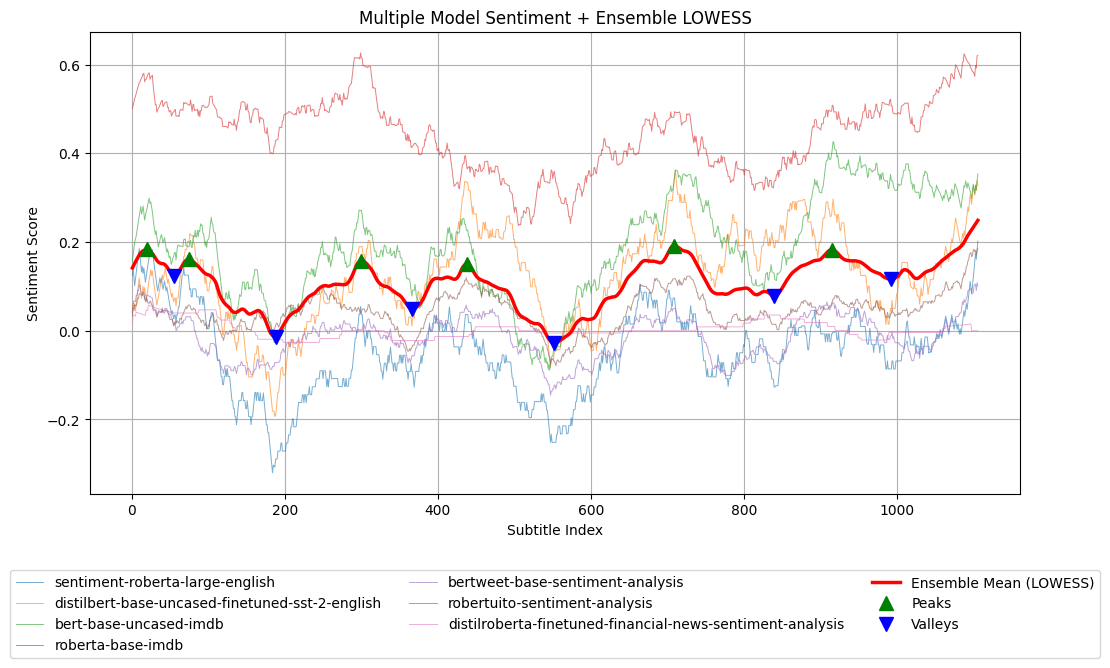

In [ ]:
plt.figure(figsize=(12, 6))


plt.figure(figsize=(12, 6))
for model_name in model_names:
    short_name = model_name.split("/")[-1]
    plt.plot(
        df["Index"],
        df[f"smoothed_score_{short_name}"],
        label=f"{short_name}",
        alpha=0.6,
        linewidth=0.7
    )

plt.plot(
    df["Index"],
    df["ensemble_mean_lowess"],
    color="red",
    linewidth=2.5,
    label="Ensemble Mean (LOWESS)"
)

# 对 ensemble_mean_lowess 进行峰谷检测
x = df["Index"].values
y = df["ensemble_mean_lowess"].values

# （distance prominence）
peaks_idx, _ = find_peaks(y, distance=30, prominence=0.02)
valleys_idx, _ = find_peaks(-y, distance=30, prominence=0.02)


plt.plot(
    df["Index"].iloc[peaks_idx],
    df["ensemble_mean_lowess"].iloc[peaks_idx],
    '^',
    color="green",
    markersize=10,
    label="Peaks"
)

plt.plot(
    df["Index"].iloc[valleys_idx],
    df["ensemble_mean_lowess"].iloc[valleys_idx],
    'v',
    color="blue",
    markersize=10,
    label="Valleys"
)

plt.title("Multiple Model Sentiment + Ensemble LOWESS")
plt.xlabel("Subtitle Index")
plt.ylabel("Sentiment Score")
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    ncol=3
)
plt.grid(True)
plt.show()

### 4. Mark words near peak/valley (Optioinal)

In [ ]:
# def print_context_around(df, center_idx, window=2):

#     start = max(0, center_idx - window)
#     end = min(len(df), center_idx + window + 1)
    
#     for i in range(start, end):
#         text = df.iloc[i]["Sentence"]
#         if i == center_idx:
#             print(f"[CRUX >>>] {text} [<<< CRUX]")
#         else:
#             print(text)
#     print("-" * 50)  


# print("=== Ensemble Peaks Context ===")
# for p_idx in peaks_idx:
#     print_context_around(df, p_idx, window=3)

# print("=== Ensemble Valleys Context ===")
# for v_idx in valleys_idx:
#     print_context_around(df, v_idx, window=3)


=== Ensemble Peaks Context ===
Drink slowly.
- Hello!
- Hello, anyone here?
[CRUX >>>] Good. [<<< CRUX]
You do what I say
when I say it.
Got you.
Thanks.
--------------------------------------------------
- Come back!
- Yin!
Let's go!
[CRUX >>>] Come on! [<<< CRUX]
We're all safe.
We're all safe.
Come here.
--------------------------------------------------
Milly!
She's gone.
We gotta keep going.
[CRUX >>>] Come on, Jia. [<<< CRUX]
What is this place?
Like an old... armory.
A barracks.
--------------------------------------------------
Look.
The underground aqueduct.
Water.
[CRUX >>>] It all makes sense. [<<< CRUX]
Huh.
Jack.
Get out
and move slowly.
--------------------------------------------------
=== Ensemble Valleys Context ===
?
I also speak Chinese.
?
[CRUX >>>] Let's go! [<<< CRUX]
Hah.
You know
that's bad for you.
Eh, not if you
only eat ten a day.
--------------------------------------------------
- Jia!
- Chen.
Is everything all right?
[CRUX >>>] What happened? [<<< CRUX]
Th